In [1]:
import tensorflow as tf
import numpy as np
import util
from timeit import default_timer as timer
from datetime import datetime
import pickle

In [2]:
XTrainTemp = util.readObject(path='pathXTrain')
YTrainTemp = util.readObject(path='pathYTrain')

XTestTemp = util.readObject(path='pathXTest')
YTestTemp = util.readObject(path='pathYTest')

XValidationTemp = util.readObject(path='pathXValidation')
YValidationTemp = util.readObject(path='pathYValidation')

xpixels_segments_train = util.readObject(path='pathSuperPixelesProcessedTrain')
xpixels_segments_test = util.readObject(path='pathSuperPixelesProcessedTest')
xpixels_segments_validation = util.readObject(path='pathSuperPixelesProcessedValidation')


numEpochs = 100

In [3]:
print(np.shape(XTrainTemp))


(23,)


In [4]:
import importlib
importlib.reload(util)

xTrain, yTrain,xTrainSuperpixeles = util.consolidateInputsAndOutputs(XTrainTemp, YTrainTemp, xpixels_segments_train)
xTest, yTest, xTestSuperpixeles = util.consolidateInputsAndOutputs(XTestTemp, YTestTemp, xpixels_segments_test)
xValidation, yValidation, yValidationSuperpixeles = util.consolidateInputsAndOutputs(XValidationTemp, YValidationTemp, xpixels_segments_validation)

yTrainCopy = yTrain
yTrain = util.integerEncoded(yTrain)
yTest = util.integerEncoded(yTest)
yValidation = util.integerEncoded(yValidation)

In [5]:
from collections import Counter
Counter(yTrainCopy)

Counter({'comment': 65,
         'decoration': 874,
         'page': 23398,
         'periphery': 759,
         'text': 23069})

In [6]:
from collections import Counter
Counter(yTrain)


Counter({0: 65, 1: 874, 2: 23398, 3: 759, 4: 23069})

In [7]:
print(np.shape(xTrain))
print(np.shape(yTrain))

print(np.shape(xTest))
print(np.shape(yTest))

print(np.shape(xValidation))
print(np.shape(yValidation))

(48165, 28, 28)
(48165,)
(16634, 28, 28)
(16634,)
(16813, 28, 28)
(16813,)


In [8]:
xTrain = xTrain.reshape((-1,28,28,1))
xTest = xTest.reshape((-1,28,28,1))
xValidation = xValidation.reshape((-1,28,28,1))
xTrain.shape, yTrain.shape

((48165, 28, 28, 1), (48165,))

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPool2D, Dropout, Input, BatchNormalization, GlobalAvgPool2D, Reshape,Multiply

def conv_layer(inp, f, k=3, s=1, bn=True, se=True, se_ratio=16) :
    out = Conv2D(f, k, strides=s, padding='same', kernel_initializer='he_uniform')(inp)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    if se:
        out_se = GlobalAvgPool2D()(out)
        r = f // se_ratio if (f // se_ratio) > 0 else 1
        out_se = Reshape((1, 1, f))(out_se) # Reshape((1, f))(out_se)
        out_se = Dense(r, use_bias=False, kernel_initializer='he_uniform', activation='relu')(out_se)
        out_se = Dense(f, use_bias=False, activation='sigmoid')(out_se)
        out = Multiply()([out, out_se])    
    return out


Using TensorFlow backend.


In [10]:
def model ():
    x   = Input(shape=(28,28,1))
    out = conv_layer(x, 32, se=True, se_ratio=16)
    out = MaxPool2D()(out)
    out = conv_layer(out, 32, se=True, se_ratio=16)
    out = MaxPool2D()(out)
    out = conv_layer(out, 32, se=True, se_ratio=16)
    out = MaxPool2D()(out)  
    out = Flatten()(out)
    out = Dense(128, kernel_initializer='he_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(5, activation='softmax')(out)
    return Model(x, out)

In [11]:
with tf.device('/gpu:0'):
    modelSE = model()


In [12]:
modelSE.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
modelSE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 28, 28, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [13]:
with tf.device('/gpu:0'):
    hist = modelSE.fit(xTrain, yTrain, validation_data=(xValidation, yValidation), epochs=numEpochs, batch_size=3500)
    #hist = model.fit(xTrain, yTrain, validation_split=0.1, epochs=20, batch_size=2048)

Train on 48165 samples, validate on 16813 samples
Epoch 1/100
48165/48165 [==============================] - 33s - loss: 0.7646 - acc: 0.7467 - val_loss: 1.3295 - val_acc: 0.4280
Epoch 2/100
48165/48165 [==============================] - 10s - loss: 0.3064 - acc: 0.9186 - val_loss: 1.1928 - val_acc: 0.5580
Epoch 3/100
48165/48165 [==============================] - 10s - loss: 0.2230 - acc: 0.9375 - val_loss: 1.2200 - val_acc: 0.5580
Epoch 4/100
48165/48165 [==============================] - 10s - loss: 0.1832 - acc: 0.9460 - val_loss: 1.3360 - val_acc: 0.5580
Epoch 5/100
48165/48165 [==============================] - 10s - loss: 0.1610 - acc: 0.9515 - val_loss: 1.4199 - val_acc: 0.5580
Epoch 6/100
48165/48165 [==============================] - 10s - loss: 0.1455 - acc: 0.9550 - val_loss: 1.5195 - val_acc: 0.5580
Epoch 7/100
48165/48165 [==============================] - 11s - loss: 0.1351 - acc: 0.9579 - val_loss: 1.4675 - val_acc: 0.5580
Epoch 8/100
48165/48165 [======================

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
95,0.999253,0.004462,0.967644,0.195407
96,0.999045,0.004758,0.967168,0.202084
97,0.999128,0.004525,0.968655,0.213261
98,0.999066,0.004564,0.967228,0.205126
99,0.998858,0.005035,0.968834,0.232977


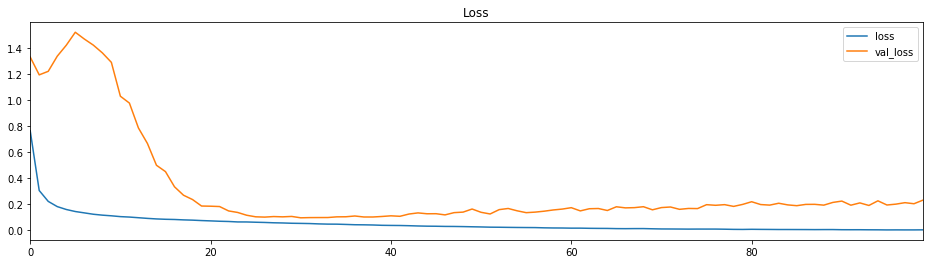

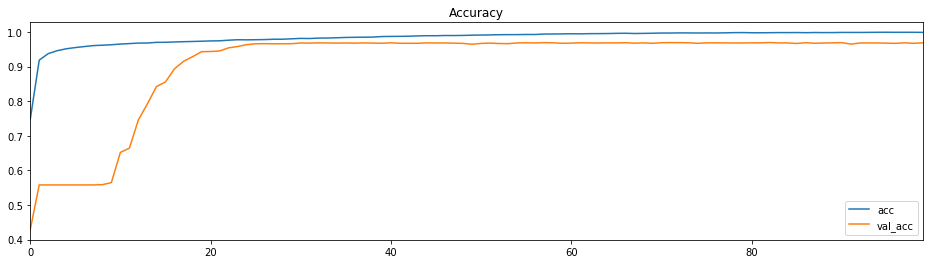

In [15]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [16]:
###saving model
##Saving weights and model
# serialize model to JSON
model_json = modelSE.to_json()
with open("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelSE.save_weights("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model1.h5py")
print("Saved model to disk")

Saved model to disk


In [17]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'
ximg_test, xgt_test = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test', 2**-3)

In [18]:
ximg_test_superpixels = util.segmentImageInSuperpixels(ximg_test, 3000)

In [1]:
#i = np.random.choice(len(ximg_test))
indexSelected = 5
superpixels = ximg_test_superpixels[indexSelected]
img = ximg_test[indexSelected]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[indexSelected]], folderGroundThruth, 'test', 2**3)


NameError: name 'ximg_test_superpixels' is not defined

In [20]:
startTime = datetime.now()
visGT = np.zeros(img.shape[:3], dtype="uint8")
visGT = util.paintGroundTruthImage(img, xgt_test[indexSelected], folderGroundThruth, 'test', 2**3)
# superpixels = listSuperPixelesProcessedTest[0]

# for j in range(len(superpixels)) :
#     if YTestToPred[0][j] == 'text' :    
#         visGT[superpixels[j] == 255] = (0, 0, 255)
#     elif YTestToPred[0][j] == 'decoration' :
#         visGT[superpixels[j] == 255] = (255, 0, 0)
#     elif YTestToPred[0][j] == 'comment' :
#         visGT[superpixels[j] == 255] = (0, 255, 0)
#     elif YTestToPred[0][j] == 'page' :
#         visGT[superpixels[j] == 255] = (255, 255, 255)
#     elif YTestToPred[0][j] == 'periphery' :
#         visGT[superpixels[j] == 255] = (0, 0, 0)

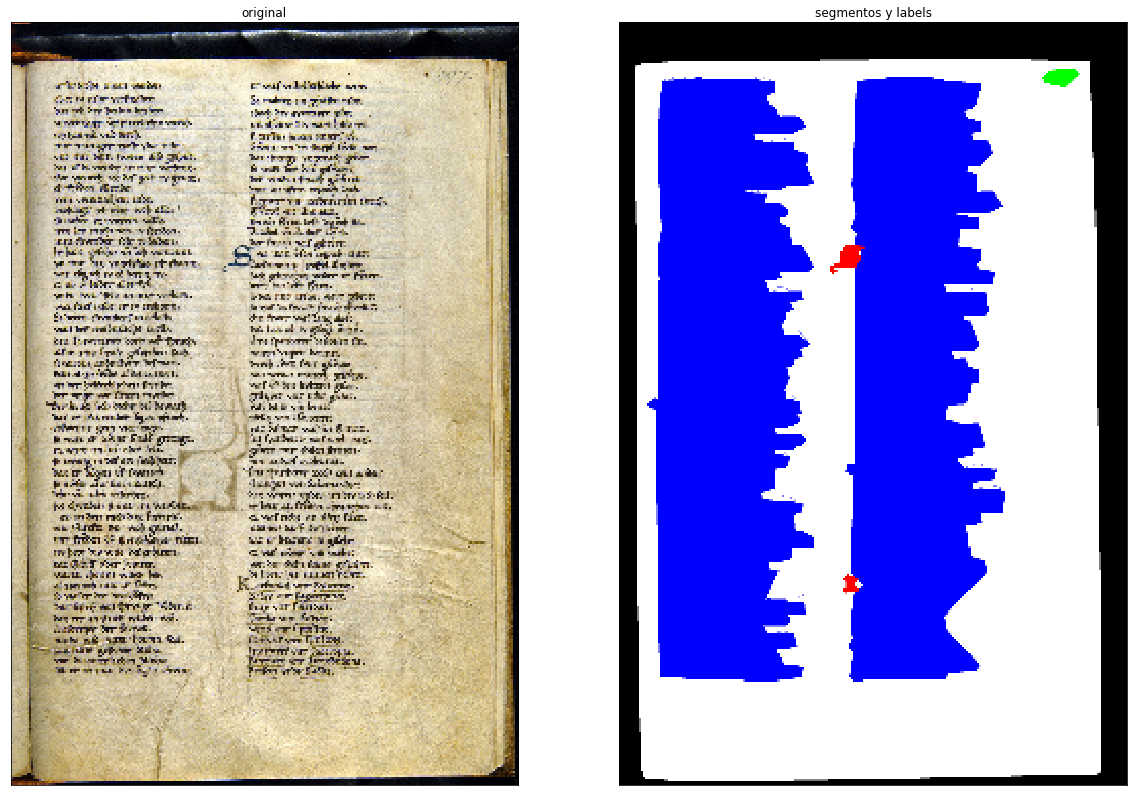

In [21]:
util.subplot(titles=['original','segmentos y labels'], images = [img, visGT], rows = 1, imgPerRows = 2, size = 20)


In [22]:
yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = np.argmax(modelSE.predict(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0])
        labels.append(predictedLabel)
    yPred.append(labels)

In [23]:
np.shape(yPred)

(1, 2066)

In [24]:
print(yPred[0][0])

3


0:comment 1:decoration 2:page 3:periphery 4:text

In [35]:
print(i)
startTime = datetime.now()
visPred = np.zeros(img.shape[:3], dtype="uint8")

for k in range(len(superpixels)) :
    if yPred[0][k] == 0 :    
        visPred[superpixels[k] == 255] = (0, 255, 0)
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = (255, 0, 0)
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = (255, 255, 255)
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = (0, 0, 0)
    elif yPred[0][k] == 4 :
        visPred[superpixels[k] == 255] = (0, 0, 255)    
 


0


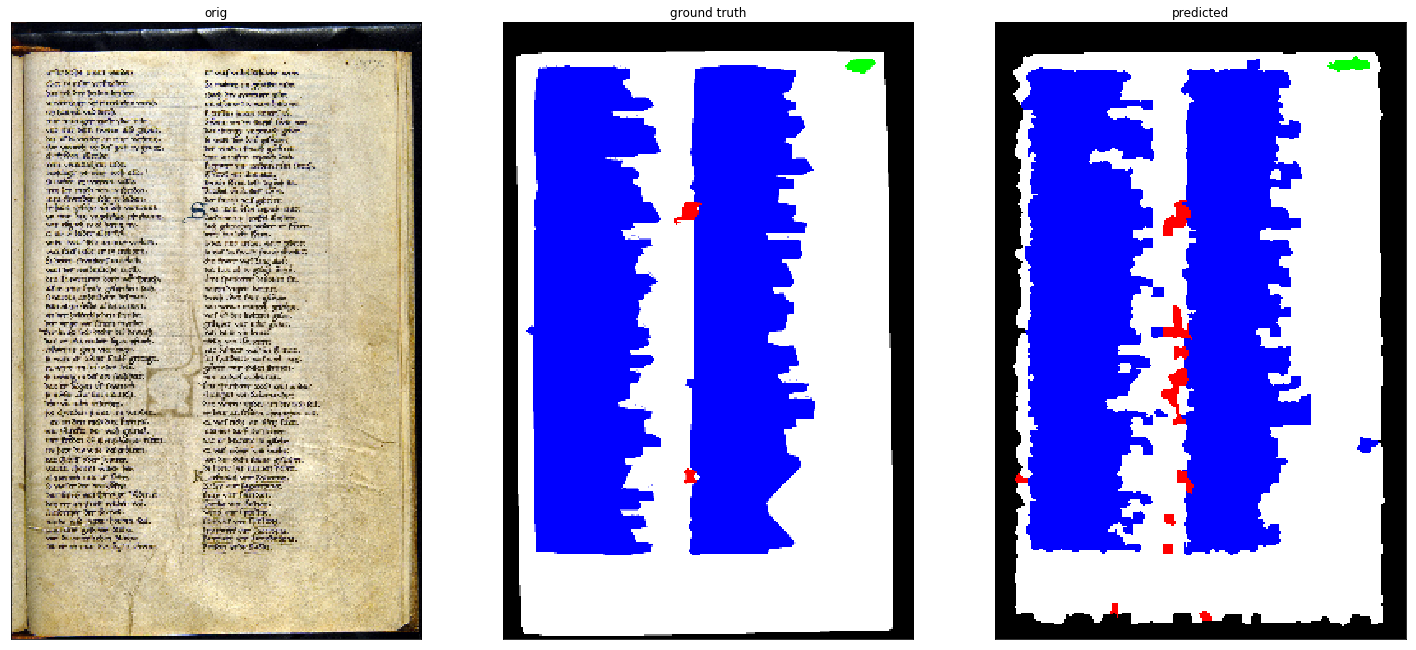

In [36]:
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])

In [27]:
def modelBasic ():
    x   = Input(shape=(28,28,1))
    out = conv_layer(x, 32, se=False)
    out = MaxPool2D()(out)
    out = conv_layer(out, 32, se=False)
    out = MaxPool2D()(out)
    out = conv_layer(out, 32, se=False)
    out = MaxPool2D()(out)  
    out = Flatten()(out)
    out = Dense(128, kernel_initializer='he_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(5, activation='softmax')(out)
    return Model(x, out)

In [28]:
with tf.device('/gpu:0'):
    model = modelBasic()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 32)        128       
__________

In [29]:
with tf.device('/gpu:0'):
    hist = model.fit(xTrain, yTrain, validation_data=(xValidation, yValidation), epochs=numEpochs, batch_size=3500)

Train on 48165 samples, validate on 16813 samples
Epoch 1/100
48165/48165 [==============================] - 10s - loss: 0.8531 - acc: 0.7230 - val_loss: 3.2538 - val_acc: 0.4150
Epoch 2/100
48165/48165 [==============================] - 9s - loss: 0.3176 - acc: 0.9175 - val_loss: 0.7343 - val_acc: 0.8524
Epoch 3/100
48165/48165 [==============================] - 9s - loss: 0.2397 - acc: 0.9331 - val_loss: 0.7002 - val_acc: 0.7538
Epoch 4/100
48165/48165 [==============================] - 9s - loss: 0.2029 - acc: 0.9407 - val_loss: 0.9388 - val_acc: 0.6396
Epoch 5/100
48165/48165 [==============================] - 9s - loss: 0.1775 - acc: 0.9475 - val_loss: 1.1638 - val_acc: 0.5928
Epoch 6/100
48165/48165 [==============================] - 9s - loss: 0.1603 - acc: 0.9503 - val_loss: 1.4182 - val_acc: 0.5760
Epoch 7/100
48165/48165 [==============================] - 9s - loss: 0.1466 - acc: 0.9552 - val_loss: 1.1720 - val_acc: 0.6321
Epoch 8/100
48165/48165 [============================

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
95,0.998671,0.006569,0.970499,0.199570
96,0.998339,0.006659,0.969369,0.204167
97,0.998443,0.006498,0.969904,0.192569
98,0.998547,0.006168,0.970083,0.198696
99,0.998671,0.005655,0.964373,0.210793


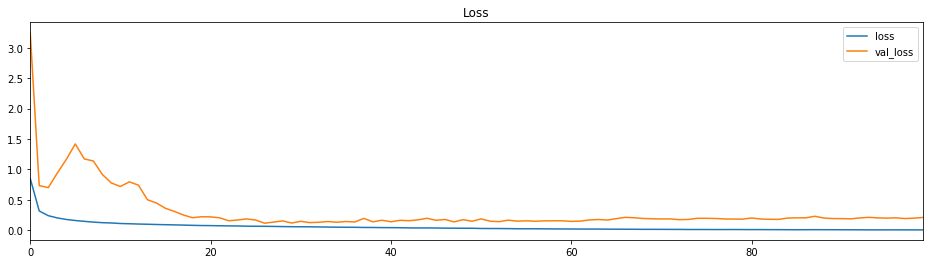

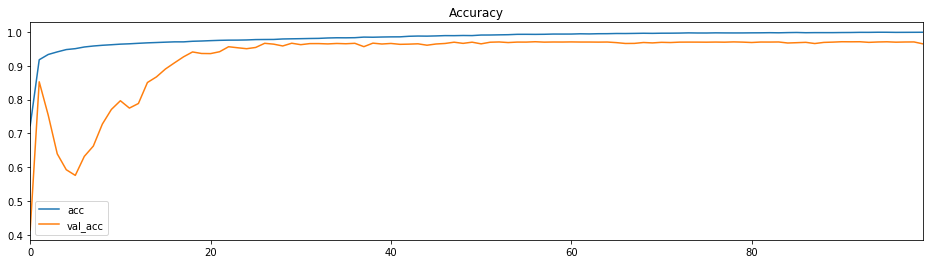

In [31]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [32]:
##Saving weights and model
# serialize model to JSON
model_json = model.to_json()
with open("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model2.h5py")
print("Saved model to disk")

Saved model to disk


In [33]:
print(np.shape(listSuperPixelesProcessedTest))
print(np.shape(yPred))
print(np.shape(ximg_test_superpixels))

(1, 2066, 376, 250)
(1, 2066)
(8, 376, 250)


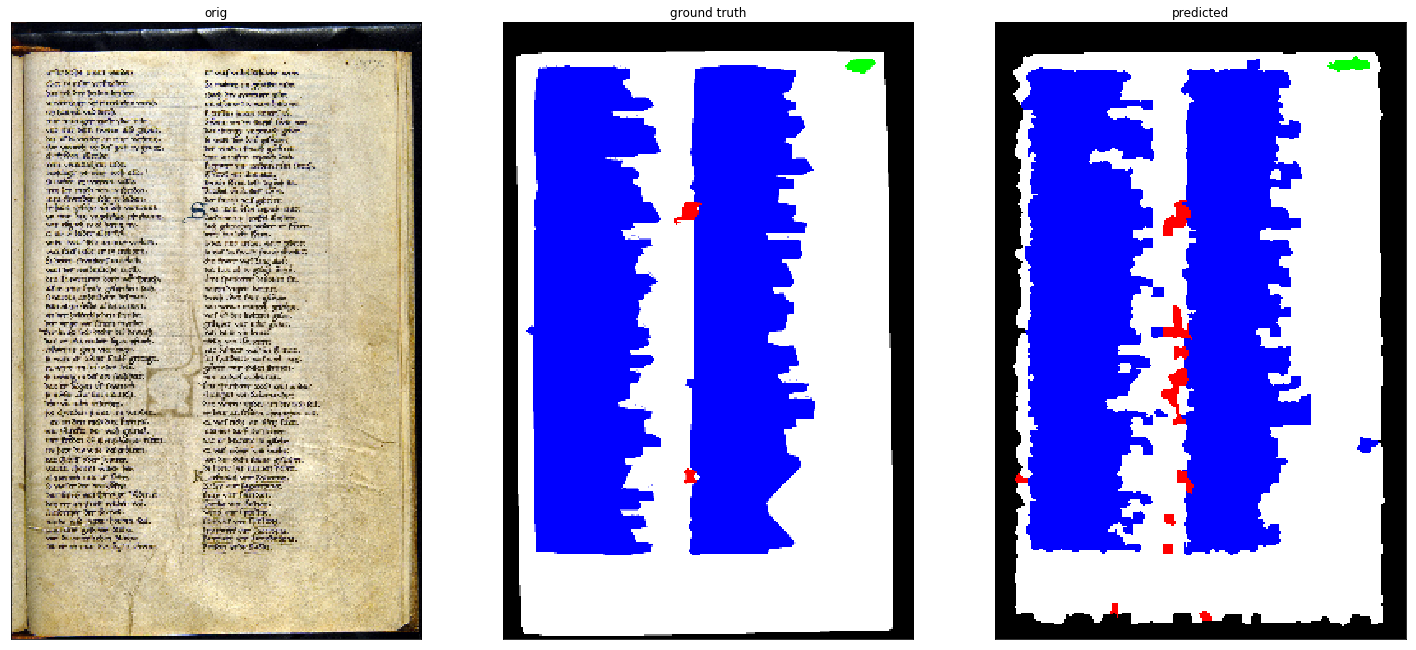

In [34]:
superpixels = ximg_test_superpixels[indexSelected]
img = ximg_test[indexSelected]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[indexSelected]], folderGroundThruth, 'test', 2**3)

startTime = datetime.now()
#isGT = np.zeros(img.shape[:2], dtype="float")
superpixels = listSuperPixelesProcessedTest[0]

yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = np.argmax(model.predict(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0])
        labels.append(predictedLabel)
    yPred.append(labels)    
    
startTime = datetime.now()
visPred = np.zeros(img.shape[:3], dtype="uint8")


for k in range(len(superpixels)) :
    if yPred[0][k] == 0 :    
        visPred[superpixels[k] == 255] = (0, 255, 0)
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = (255, 0, 0)
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = (255, 255, 255)
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = (0, 0, 0)
    elif yPred[0][k] == 4 :
        visPred[superpixels[k] == 255] = (0, 0, 255)    
        
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])        